In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import sys
from gen_catalyst_design.db import Database, get_atoms_list_db, load_data_from_db
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [12]:
miller_index = "100"
pth_header = f"results/Rh_Cu_Au_Pd/miller_index_{miller_index}"
run_ids = [0,1,2]
datadicts = []
for run_id in run_ids:
    filename = f"runID_{run_id}_results.db"
    database = Database.establish_connection(filename=filename, miller_index=miller_index, pth_header=pth_header)
    datadicts += load_data_from_db(database=database)

datadicts = sorted(datadicts, key=lambda xx: xx["rate"], reverse=False)
print(datadicts[0]["rate"])

9.340695213105166e-11


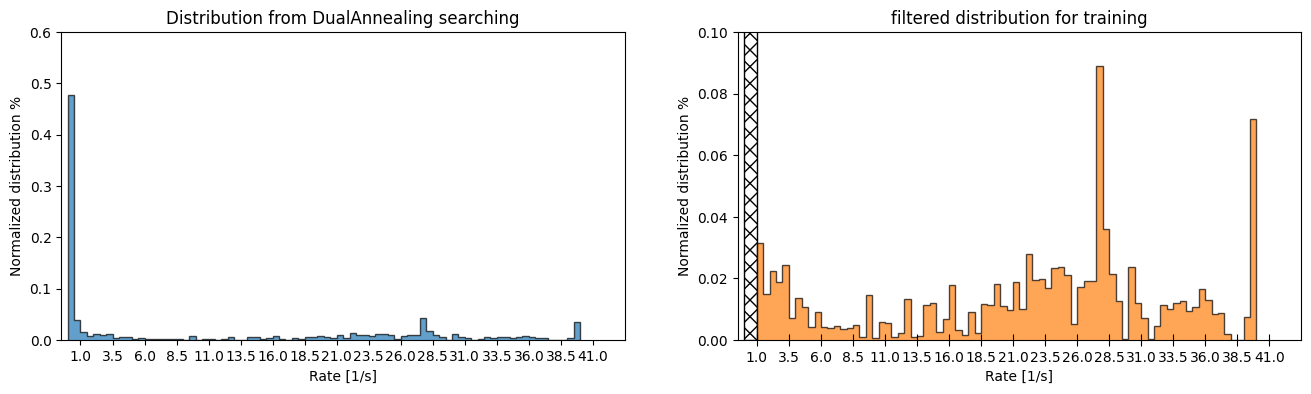

In [17]:
fig, axs = plt.subplots(1,2, figsize=(16,4), sharex=True)
rates = np.array([datadict["rate"] for datadict in datadicts])
rate_interval = 0.5
rate_max = np.max(rates)


i = 0
hist_prior = None
y_lims = [0.6, 0.1]
titles = [
    "Distribution from DualAnnealing searching",
    "filtered distribution for training"
]

step = 2.5
classes = np.arange(1.0, np.ceil(rate_max)+step, step)#np.linspace(1.0, np.ceil(rate_max), 5)
for ax, rate_min, color in zip(axs, [0.0, 1.0], ["C0", "C1"]):
    bins = np.arange(rate_min, rate_max, rate_interval)
    hist, edges = np.histogram(rates, bins=bins)
    hist_norm = hist/np.sum(hist)
    if i == 1:
        ax.bar(0.5, 1.0, width=1.0, fill=False, hatch="xx")
        ax.set_xticks(classes)
        ax.tick_params(axis='x', direction='inout', length=8)
        #for val in classes:
        #    ax.set_xticks()
            #ax.vlines(x=val, ymin=0.0, ymax=0.05, colors="k", linewidth=1)
        #    ax.tick_params(axis='x', direction='inout')
    #else:
    ax.stairs(hist_norm, edges=edges, fill=True, alpha=0.7, edgecolor="k", linewidth=1, color=color)
    ax.set_title(titles[i])
    ax.set_xlim([-0.5, np.ceil(rate_max)+step])
    ax.set_ylim([0.0, y_lims[i]])
    ax.set_ylabel("Normalized distribution %")
    ax.set_xlabel("Rate [1/s]")
    i+=1

In [4]:
def element_to_onehot(element, mapping_dict):
    onehot = np.zeros(len(mapping_dict))
    onehot[mapping_dict[element]] +=1
    return onehot

def get_onehots(datadicts, element_pool):
    mapping_dict = {element:i for i, element in enumerate(element_pool)}
    result_onehots = []
    for datadict in datadicts:
        elements = datadict["elements"]
        onehots = np.hstack([element_to_onehot(element=element, mapping_dict=mapping_dict) for element in elements])
        result_onehots.append(onehots)
    return np.vstack(result_onehots)

def assign_classes(datadicts, classes, num_classes):
    class_divs = {}
    for i in range(num_classes):
        for j, datadict in enumerate(datadicts):
            rate = datadict["rate"]
            if rate > classes[i] and rate < classes[i+1]:
                if i in class_divs:
                    class_divs[i].append(j)
                else:
                    class_divs[i] = [j]
    return class_divs


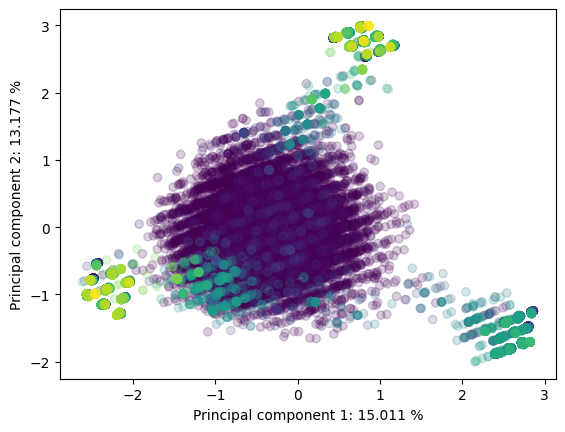

In [5]:
fig, ax = plt.subplots()
element_pool = ["Rh", "Cu", "Au", "Pd"]
onehots = get_onehots(datadicts=datadicts, element_pool=element_pool)
pca = PCA(n_components=2)
transformed = pca.fit_transform(onehots)
ax.set_xlabel(f"Principal component 1: {(pca.explained_variance_ratio_[0]*100).round(3)} %")
ax.set_ylabel(f"Principal component 2: {(pca.explained_variance_ratio_[1]*100).round(3)} %")
num_classes = 5
rate_min = 1.0
classes = np.linspace(rate_min, rate_max, num_classes+1)
class_divs = assign_classes(datadicts=datadicts, classes=classes, num_classes=num_classes)


cmap = plt.cm.viridis

ax.scatter(transformed[:,0], transformed[:,1], c=rates, cmap=cmap, vmin=rate_min, vmax=rate_max, alpha=0.2)

#for div in class_divs:
#    indices = class_divs[div]
#    ax.plot(transformed[indices][:,0], transformed[indices][:,1], 'o', alpha=0.4, color=f"C{div}")

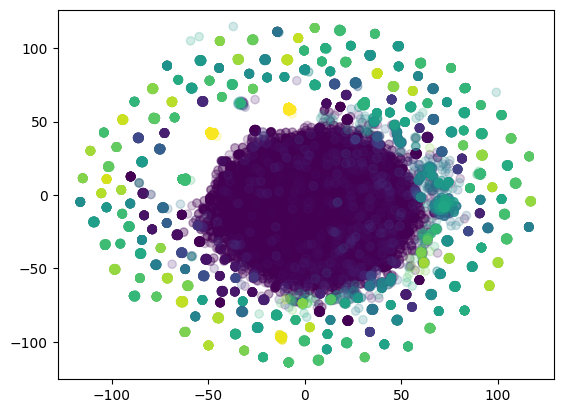

In [6]:
fig, ax = plt.subplots()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(onehots)

cmap = plt.cm.viridis

ax.scatter(X_embedded[:,0], X_embedded[:,1], c=rates, cmap=cmap, vmin=rate_min, vmax=rate_max, alpha=0.2)

#for div in class_divs:
#    indices = class_divs[div]
#    ax.plot(X_embedded[indices][:,0], X_embedded[indices][:,1], 'o', alpha=0.2, color=f"C{div}")

In [7]:
def filter_datadicts(datadicts, rate_min):
    filtered_dicts = []
    for datadict in datadicts:
        rate = datadict["rate"]
        if rate >= rate_min:
            filtered_dicts.append(datadict)
    return filtered_dicts

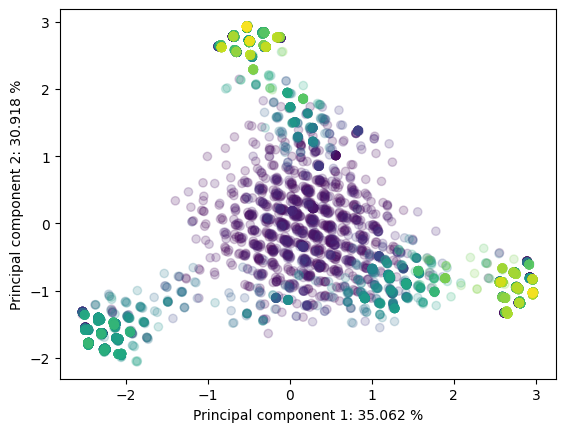

In [8]:
fig, ax = plt.subplots()
element_pool = ["Rh", "Cu", "Au", "Pd"]

filtered_datadicts = filter_datadicts(datadicts=datadicts, rate_min=1.0)

onehots = get_onehots(datadicts=filtered_datadicts, element_pool=element_pool)
pca = PCA(n_components=2)
transformed = pca.fit_transform(onehots)
ax.set_xlabel(f"Principal component 1: {(pca.explained_variance_ratio_[0]*100).round(3)} %")
ax.set_ylabel(f"Principal component 2: {(pca.explained_variance_ratio_[1]*100).round(3)} %")
num_classes = 5
rate_min = 1.0

rates = [datadict["rate"] for datadict in filtered_datadicts]
#classes = np.linspace(rate_min, rate_max, num_classes+1)
#print(classes)
#class_divs = assign_classes(datadicts=filtered_datadicts, classes=classes, num_classes=num_classes)

cmap = plt.cm.viridis

ax.scatter(transformed[:,0], transformed[:,1], c=rates, cmap=cmap, vmin=rate_min, vmax=rate_max, alpha=0.2)

#for div in class_divs:
#    indices = class_divs[div]
#    ax.plot(transformed[indices][:,0], transformed[indices][:,1], 'o', alpha=0.4, color=f"C{div}")

In [9]:
fitltered_rates = [datadict["rate"] for datadict in filtered_datadicts]
print(min(fitltered_rates))

1.0019502967586595


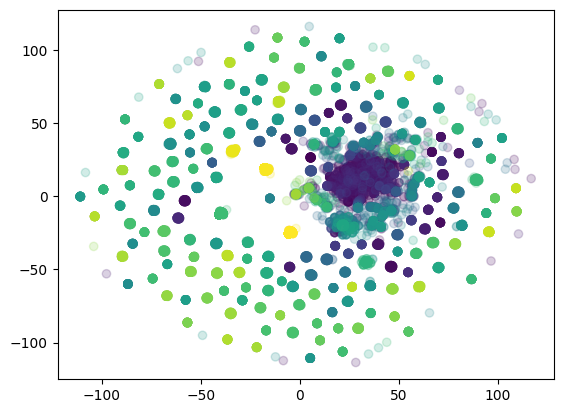

In [10]:
fig, ax = plt.subplots()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(onehots)

cmap = plt.cm.viridis

ax.scatter(X_embedded[:,0], X_embedded[:,1], c=rates, cmap=cmap, vmin=rate_min, vmax=rate_max, alpha=0.2)
#for div in class_divs:
#    indices = class_divs[div]
#    ax.plot(X_embedded[indices][:,0], X_embedded[indices][:,1], 'o', alpha=0.6, color=f"C{div}")